<a id="top"></a>
# Vegetation Phenology
<hr>

# Notebook Summary

* LANDSAT 7, LANDSAT 8, or both are used to detect changes in plant life over time.
* Either NDVI or EVI may be used as a indicator of vegatation.
* The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.

<hr>

# Index  

* [Import Dependencies and Connect to the Data Cube](#Vegetation_Phenology_import)
* [Choose Platform and Product](#Vegetation_Phenology_plat_prod)
* [Get the Maximum Extents of the Cube](#Vegetation_Phenology_extents)
* [Define the Extents of the Analysis](#Vegetation_Phenology_define_extents) (selecting too much can make the acquisition process slow)
* [Load Data from the Data Cube](#Vegetation_Phenology_retrieve_data)
* [Calculate Vegetation Index](#Vegetation_Phenology_calculate)
* [Examine the Selected Area](#Vegetation_Phenology_area_analysis)
* [Create a Max NDVI Composite](#Vegetation_Phenology_mosaic)
* [Export the Mosaic to a PNG and a GeoTIFF](#Vegetation_Phenology_export)

<hr>

# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between the amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The intention is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy. When they aren't healthy, more of that light will get reflected, making the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller, which will lower the <font color=green>NDVI</font> value. So a higher NDVI indicates a higher degree of vegetation.
</div>

However, we can also use a measure called EVI.
<br>

$$ EVI =  G * \frac{(NIR - RED)}{(NIR + C1*RED-C2*BLUE+L)}$$  

<br>
<div class="alert-info">
    EVI is superior to NDVI in accuracy because it is less dependent on the solar
    incidence angle, atmospheric conditions (e.g. particles and clouds), shadows, and
    soil appearance. Normally, $G=2.5$, $C1=6$, $C2=7.5$, and $L=1$.
</div>

Additionally, there is a 2-band version of EVI called EVI2.
<br>

$$ EVI2 = G * \frac{(NIR - RED)}{(NIR + C*RED+L)}$$

<br>
<div class="alert-info">
    EVI2 does not require a blue band like EVI, which means less data is required to use it.
    Additionally, the blue band used in EVI can have a low signal-to-noise ratio 
    in earth observation imagery. When atmospheric effects are insignificant (e.g. on clear days),
    EVI2 should closely match EVI. Normally, $G=2.5$, $C=2.4$, and $L=1$.
</div>

## <span id="Vegetation_Phenology_import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt

from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_display_map import display_map

# Dependencies for loading multiple products.
from utils.data_cube_utilities.dc_load import match_dim_sizes
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.aggregate import xr_scale_res
from utils.data_cube_utilities.dc_load import is_dataset_empty
from utils.data_cube_utilities.sort import xarray_sortby_coord

from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
from utils.data_cube_utilities.dc_rgb import rgb

from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI, EVI, EVI2

from utils.data_cube_utilities.dc_utilities import write_png_from_xr
from utils.data_cube_utilities.import_export import export_xarray_to_multiple_geotiffs

In [2]:
# Create an instance of the datacube and API.
api = DataAccessApi()
dc = api.dc

## <span id="Vegetation_Phenology_plat_prod">Choose Platform and Product [&#9652;](#top)</span>

In [3]:
# Get available products
products_info = dc.list_products()

In [4]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


In [6]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = True
use_Landsat8 = False
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_ghana')

## <span id="Vegetation_Phenology_extents">Get the Maximum Extents of the Cube [&#9652;](#top)</span>

In [7]:
for product, platform in zip(products, platforms):
    prod_extents = api.get_query_metadata(platform=platform, product=product, measurements=[])

    latitude_extents = prod_extents['lat_extents']
    longitude_extents = prod_extents['lon_extents']
    time_extents = list(map(lambda time: time.strftime('%Y-%m-%d'), prod_extents['time_extents']))

    print("{}:".format(platform))
    print("Lat bounds:", latitude_extents)
    print("Lon bounds:", longitude_extents)
    print("Time bounds:", time_extents)

LANDSAT_7:
Lat bounds: (array(3.77305894), array(11.31863783))
Lon bounds: (array(-3.77278945), array(1.88632735))
Time bounds: ['2000-01-01', '2020-01-10']


In [8]:
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <span id="Vegetation_Phenology_define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

**Specify start and end dates in the same order as platforms and products**

In [9]:
# Use these four lines to select the time slice common to all products.
# min_start_date_mutual = np.max(min_max_dates[:,0])
# max_end_date_mutual = np.min(min_max_dates[:,1])
# start_dates = [min_start_date_mutual, min_start_date_mutual]
# end_dates = [max_end_date_mutual, max_end_date_mutual]
# Use these two lines to select all data available to each product.
# start_dates = min_max_dates[:,0]
# end_dates = min_max_dates[:,1]

# Select a subset of the time available.
start_date, end_date = "2016-01-01", "2016-12-31"
# start_date, end_date = "2014-09-01", "2015-01-31"

**Specify an area to analyze**

In [10]:
# Specify latitude and longitude bounds of an interesting area within the full extents

# Ghana
# Crops NW of Accra (small)
lat_small = (5.7261, 5.7390)
lon_small = (-0.4960, -0.4889)
# Crops NW of Accra (medium)
# lat_small = (5.7259, 5.7517) 
# lon_small = (-0.5308, -0.5143)
# Central Ghana - West of Kintampo
# lat_small = (8.0074, 8.0203) 
# lon_small = (-2.0486, -2.0332)
    
# Vietnam
# Area #1
# lat_small = (10.95, 11.00)
# lon_small = (107.15, 107.20)
# Area #2
# lat_small = (11.10, 11.39)
# lon_small = (106.8, 106.92)
# Area #3
# lat_small = (9.8, 10.0)
# lon_small = (105.2, 105.4)
# Area #4
# lat_small = (9.9, 10.1)
# lon_small = (105.0, 105.2)

**Visualize the selected area**

In [11]:
display_map(lat_small, lon_small)

## <span id="Vegetation_Phenology_retrieve_data">Load Data from the Data Cube [&#9652;](#top)</span>

In [12]:
# Select which spectral index to use to track changes in vegetation.
# Can be any of ['NDVI', 'EVI', 'EVI2'].
spectral_index = 'EVI2'

if spectral_index == 'NDVI':
    measurements = ['red', 'nir']
elif spectral_index == 'EVI':
    measurements = ['red', 'nir', 'blue']
else: # EVI2
    measurements = ['red', 'nir']
# Include pixel_qa band to obtain the clean mask in load_multiplatform.
# Include red, green, and blue bands to be able to show RGB images of the data.
measurements = list(set(measurements + ['pixel_qa', 'red', 'green', 'blue']))

matching_abs_res, same_dim_sizes = \
    match_dim_sizes(dc, products, lon_small, lat_small)
datasets = {}
clean_masks = {}
for platform, product in zip(platforms, products):
    # Load the dataset.
    dataset = dc.load(platform=platform, product=product, 
                      lat=lat_small, lon=lon_small, 
                      time=time_extents, measurements=measurements,
                      group_by='solar_day')
    if is_dataset_empty(dataset):
        continue
    # Get the masks (varies by platform).
    # The astype cast is for `xr_scale_res()` below.
    clean_mask = (landsat_qa_clean_mask(dataset, platform) & 
                  (dataset != -9999).to_array().all('variable') & 
                  landsat_clean_mask_invalid(dataset))
    dataset = dataset.drop('pixel_qa')    
    # (Optional) Discard acquisitions with no clean data.
    acq_times_to_keep = dataset.time.values[(clean_mask.mean(['latitude', 'longitude']) > 0.001).values]
    dataset = dataset.sel(time=acq_times_to_keep)
    clean_mask = clean_mask.sel(time=acq_times_to_keep)
    # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
    if not same_dim_sizes:    
        dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
        clean_mask = xr_scale_res(clean_mask.astype(np.uint8), abs_res=matching_abs_res).astype(np.bool)
    # Clean the data.
    dataset = dataset.where(clean_mask)
    datasets[product], clean_masks[product] = dataset, clean_mask
# Combine everything.
if len(datasets) > 0:
    # Make the coordinates of the datasets the same as the first.
    for i in range(1, len(platforms)):
        for coord in ['latitude', 'longitude']:
            datasets[platforms[i]][coord].values = \
                datasets[platforms[0]][coord].values
    dataset = xr.concat(list(datasets.values()), dim='time').sortby('time')
    clean_mask = xr.concat(list(clean_masks.values()), dim='time').sortby('time')
else:
    dataset = xr.Dataset()
    clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
del datasets, clean_masks

cleaned_dataset = dataset.where(clean_mask)
del dataset # Save memory

## <span id='Vegetation_Phenology_calculate'>Calculate Vegetation Index [&#9652;](#top)</span>

In [13]:
if spectral_index == 'NDVI':
    vegetation_arr = NDVI(cleaned_dataset)
elif spectral_index == 'EVI':
    vegetation_arr = EVI(cleaned_dataset)
else: # 'EVI2'
    vegetation_arr = EVI2(cleaned_dataset)
cleaned_dataset[spectral_index] = vegetation_arr

## <span id="Vegetation_Phenology_area_analysis">Examine the Selected Area [&#9652;](#top)</span>

**If no plots appear in the figures below, there is no data available for the region selected**

**Box-and-Whisker Plot by Full Time Period, Week, Month, Week of Year, or Month of Year.**

EVI2 (Aggregated by Month of Year)


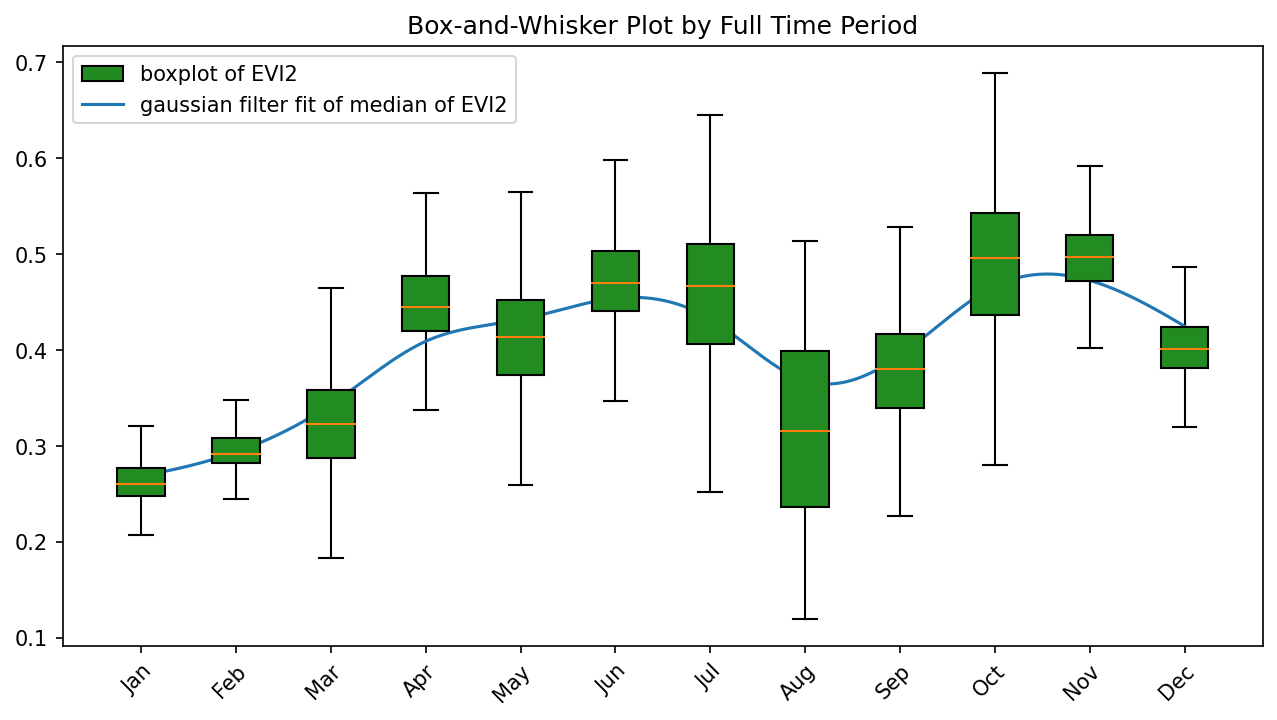

In [14]:
import warnings

## Settings ##

# Specify the type of curve fit to use for the vegetation index along time.
# Can be one of [None, 'gaussian', 'gaussian_filter', 'poly', 'cubic_spline'].
# Using None will not plot a curve fit.
curve_fit_type = 'gaussian_filter'
assert curve_fit_type in [None, 'gaussian', 'gaussian_filter', 'poly', 'cubic_spline'], \
    "The variable `curve_fit_type` must be in " \
    "[None, 'gaussian', 'gaussian_filter', 'poly', 'cubic_spline']"

# Specify the target aggregation type of the curve fit. Input can be either 'mean' or 'median'.
curve_fit_target = 'median'
assert curve_fit_target in ['mean', 'median'], "The variable 'curve_fit_target' must be either "\
                                               "'mean' or 'median'."

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 10

## End Settings ##

# Can be one of [None, 'week', 'month', 'weekofyear', 'monthofyear'].
with warnings.catch_warnings():
    # Ignore warning about aggregations of empty slices.
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for bin_by in ['monthofyear']:
        aggregated_by_str = None
        if bin_by is None:
            plotting_data = cleaned_dataset
        elif bin_by == 'week':
            plotting_data = cleaned_dataset.resample(time='1w').mean()
            aggregated_by_str = 'Week'
        elif bin_by == 'month':
            plotting_data = cleaned_dataset.resample(time='1m').mean()
            aggregated_by_str = 'Month'
        elif bin_by == 'weekofyear':
            plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
            aggregated_by_str = 'Week of Year'
        elif bin_by == 'monthofyear':
            plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
            aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, 
              plot_descs={spectral_index:{'none':[{'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if curve_fit_type is not None:
    if curve_fit_type == 'gaussian':
        curve_fit_desc = [{'gaussian': {}}]
    elif curve_fit_type == 'gaussian_filter':
        curve_fit_desc = [{'gaussian_filter': {}}]
    elif curve_fit_type == 'poly':
        curve_fit_desc = [{'poly': {'degree': 3}}]
    else: # 'cubic_spline'
        curve_fit_desc = [{'cubic_spline': {}}]
    params['plot_descs'][spectral_index][curve_fit_target] = curve_fit_desc
    
fig, _ = xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Box-and-Whisker Plot by Full Time Period')
agg_str = "(Aggregated by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""
print("{} {}".format(spectral_index, agg_str))

## <span id="Vegetation_Phenology_mosaic">Create a Max NDVI Composite [&#9652;](#top)</span>

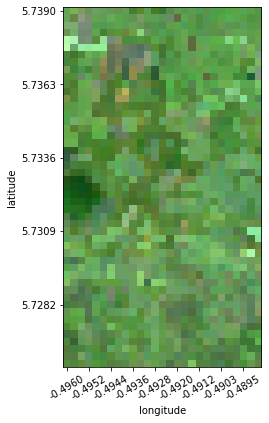

In [15]:
max_ndvi_mosaic = create_max_ndvi_mosaic(cleaned_dataset, clean_mask)
rgb(max_ndvi_mosaic, use_data_min=True, use_data_max=True, min_inten=0.05,
    width=12)
plt.show()

## <span id="Vegetation_Phenology_export">Export the Mosaic to a PNG and a GeoTIFF [&#9652;](#top)</span>

**Export to PNG**

In [16]:
import os
import pathlib
png_dir = 'output/pngs'
pathlib.Path(png_dir).mkdir(parents=True, exist_ok=True)
write_png_from_xr('{}/NDVI_Phenology_Max_NDVI_Mosaic.png'.format(png_dir), max_ndvi_mosaic, ['red','green','blue'], scale=(0,4000))

**Export to GeoTIFF**

In [17]:
geotiff_dir = 'output/geotiffs/NDVI_Phenology'
pathlib.Path(geotiff_dir).mkdir(parents=True, exist_ok=True)
export_xarray_to_multiple_geotiffs(cleaned_dataset, "{}/NDVI_Phenology".format(geotiff_dir))